### R9 AIML Sequential NLP Project-2
#### Domain - Social media analytics.
#### Project - Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.

DATA DESCRIPTION: Content: Each record consists of three attributes:
is_sarcastic: 1 if the record is sarcastic otherwise 0
headline: the headline of the news article
article_link: link to the original news article. Useful in collecting supplementary data
Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

In [42]:
#Import libraries
import os
%matplotlib inline
import matplotlib.pyplot as plt # Data Visualization
import pandas as pd # Data processing
import seaborn as sns # Data Visualization
import numpy as np # Linear Algebra
import tensorflow as tf #Tensor Flow
from sklearn import preprocessing #preprocessing libraries from sklearn

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

#Import libraries for this project
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten


#### STEP1. Read and explore the data

In [43]:
path  = "https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json"

In [44]:
dataset = pd.read_json(path, lines=True)

In [45]:
dataset

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [46]:
print("This dataset has ", dataset.shape[0], "rows and ", dataset.shape[1],"columns")

This dataset has  28619 rows and  3 columns


#### STEP2. Retain relevant columns

In [47]:
#remove article link as it is not relevant for our analysis
dataset.drop(columns= "article_link", axis = 1, inplace=True)

In [48]:
#check any null values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [49]:
#check data distribution and object column unique data
dataset.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_sarcastic,28619,NaN,NaN,NaN,0.476397,0.499451,0,0,0,1,1
headline,28619,28503,"'no way to prevent this,' says only nation whe...",12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Mean is 47%, data is fairly distributed between two classes.
* Repeat headline is present as unique count is less than the dataset row count

In [50]:
# remove duplicates
dataset.drop_duplicates(inplace=True)

In [51]:
print("After duplicates removal this dataset has ", dataset.shape[0], "rows and ", dataset.shape[1],"columns")

After duplicates removal this dataset has  28503 rows and  2 columns


In [52]:
print("Dataset has ",dataset.is_sarcastic.value_counts()[1] ,"headlines marked as sarcastic and remaining ",dataset.is_sarcastic.value_counts()[0]," headlines as otherwise")

Dataset has  13552 headlines marked as sarcastic and remaining  14951  headlines as otherwise


#### STEP3. Get length of each sentence

In [53]:
dataset['length']=dataset['headline'].apply(lambda x: len(x.split()))

In [54]:
dataset['length'].describe()

count    28503.000000
mean        10.060871
std          3.385275
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max        151.000000
Name: length, dtype: float64

* Sentence with minimum length is 2 words
* Sentence with maximum length is 151 words
* Sentences is having average length is 10 words

#### STEP4. Define parameters

In [55]:
max_features = 35000
maxlen = 200
embedding_size = 100


#### STEP5. Get indices for words

In [69]:
from tensorflow.keras.preprocessing.text import Tokenizer
token = Tokenizer(num_words = max_features)
## Fit on Text data
token.fit_on_texts(dataset['headline'])
## Convert to Sequences 
X = token.texts_to_sequences(dataset['headline'])

# Get max training sequence length
maxlen = max([len(x) for x in X])

print("Max length : ",maxlen,'\n')

print("Num of samples:" , len(X), '\n')

print("Num of words:" , len(token.word_index))

Max length :  152 

Num of samples: 28503 

Num of words: 30884


#### STEP6. Create features and labels

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences( X,padding='pre',maxlen = maxlen)
y = np.asarray(dataset['is_sarcastic'])

In [ ]:
print("Shape of feature set", X.shape)
print("Shape of label set",y.shape)

Shape of feature set (28503, 152)
Shape of label set (28503,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size = 0.3)

#### STEP7. Get vocabulary size

In [ ]:
num_words = len(token.word_index) + 1
print(" Vocabulary Size :", num_words)

 Vocabulary Size : 30885


#### STEP8. Create a weight matrix using GloVe embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#from zipfile import ZipFile
#with ZipFile('/content/drive/MyDrive/glove.twitter.27B.100d.txt.zip','r') as z:
#  z.extractall()

In [ ]:
!ls -ltr

total 1036960
drwx------ 5 root root       4096 May 31 15:55 drive
-rw-r--r-- 1 root root 1021669379 May 31 15:57 glove.twitter.27B.100d.txt
-rw-r--r-- 1 root root   40164632 May 31 16:35 lstm.h5


In [ ]:
embedding_file = "/content/glove.twitter.27B.100d.txt"
embedding = {}

for o in open(embedding_file):
    word = o.split(" ")[0]
    embd = np.asarray(o.split(" ")[1:] , dtype = 'float32')
    embedding[word] = embd


In [ ]:
len(embedding)

1193514

In [ ]:
embedding_matrix = np.zeros((num_words,100))

for word,i in token.word_index.items():
  if word in embedding.keys():
    embedding_matrix[i] = embedding[word]

In [ ]:
embedding_matrix.shape

(30885, 100)

#### STEP9. Define and compile a Bidirectional LSTM model

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional
#Defining Neural Network
model = Sequential()

#Trainable embeddidng layer (We retain the pretrained glove embedding matrix with our data)
model.add(Embedding(input_dim=num_words, output_dim=embedding_size, weights=[embedding_matrix], input_length=152, trainable=True))
#LSTM 
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128,dropout = 0.5)))

# latent space
model.add(tf.keras.layers.Dense( units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense( units=32, activation='relu'))
model.add(Dropout(0.5))

# In decoder secton, Sigmoid as activation function and binary  cross entropoy as loss function used for binary classification
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 152, 100)          3088500   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

#### STEP10. Fit the model and check the validation accuracy

In [ ]:
# save the best model to the checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('lstm.h5', #where to save the model
                                                save_best_only=True, 
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_weights_only=False,
                                                verbose = 1)

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='training_accuracy')
  plt.plot(history.history['val_accuracy'], label='validation_accuracy')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend(['training', 'validation'], loc='best')
  plt.grid(True)

def plot_loss(history):
  plt.plot(history.history['loss'], label='training_loss')
  plt.plot(history.history['val_loss'], label='validation_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend(['training', 'validation'], loc='best')
  plt.grid(True)

def plotting(name):
  print('\n')
  print('\033[1m',name)
  plt.figure(figsize=(15,5))
  #plt.rcParams.update({'font.size': 10})
  plt.subplot(1,2,1)
  # Accuracy vs Epochs
  plot_accuracy(history)
  plt.subplot(1,2,2)
  # Loss vs Epochs
  plot_loss(history)

Epoch 1/10
624/624 [==============================] - 32s 44ms/step - loss: 0.5222 - accuracy: 0.7501 - val_loss: 0.3613 - val_accuracy: 0.8563

Epoch 00001: val_accuracy improved from -inf to 0.85627, saving model to lstm.h5
Epoch 2/10
624/624 [==============================] - 26s 41ms/step - loss: 0.3024 - accuracy: 0.8897 - val_loss: 0.3365 - val_accuracy: 0.8627

Epoch 00002: val_accuracy improved from 0.85627 to 0.86271, saving model to lstm.h5
Epoch 3/10
624/624 [==============================] - 25s 41ms/step - loss: 0.2034 - accuracy: 0.9281 - val_loss: 0.4213 - val_accuracy: 0.8598

Epoch 00003: val_accuracy did not improve from 0.86271
Epoch 4/10
624/624 [==============================] - 26s 41ms/step - loss: 0.1509 - accuracy: 0.9493 - val_loss: 0.4997 - val_accuracy: 0.8541

Epoch 00004: val_accuracy did not improve from 0.86271
Epoch 5/10
624/624 [==============================] - 26s 41ms/step - loss: 0.1217 - accuracy: 0.9610 - val_loss: 0.6758 - val_accuracy: 0.8504



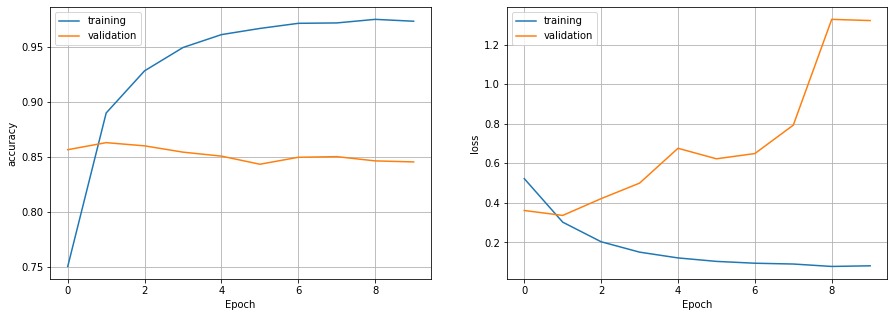

In [ ]:
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint])
# Scores achieved for the model # achieved at epoch
best_epoch = pd.DataFrame(history.history['val_accuracy']).idxmax().values
validation_accuracy = pd.DataFrame(history.history['val_accuracy']).iloc[best_epoch,0]
Train_accuracy = pd.DataFrame(history.history['accuracy']).iloc[best_epoch,0]
validation_loss = pd.DataFrame(history.history['val_loss']).iloc[best_epoch,0]
Train_loss = pd.DataFrame(history.history['loss']).iloc[best_epoch,0]
plotting('BidirectionRNN_Model')
print('Training Accuracy: %.2f and loss: %.2f' %(Train_accuracy*100, Train_loss)  )
print('Validation Accuracy: %.2f and loss :%.2f' %(validation_accuracy*100, validation_loss))

In [ ]:
predicted = model.predict_classes(X_test)
predicted[:5]

array([[0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, predicted, target_names = ['Otherwise','Sarcastic']))

              precision    recall  f1-score   support

   Otherwise       0.84      0.87      0.85      4440
   Sarcastic       0.85      0.82      0.84      4111

    accuracy                           0.85      8551
   macro avg       0.85      0.84      0.84      8551
weighted avg       0.85      0.85      0.84      8551



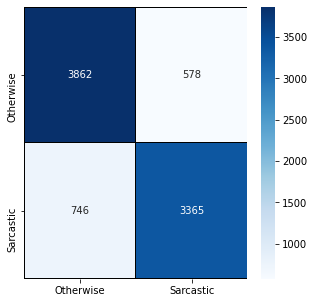

In [ ]:
cm = confusion_matrix(y_test,predicted)
df = pd.DataFrame(cm , index = ['Otherwise','Sarcastic'] , columns = ['Otherwise','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(df,cmap= "Blues", linecolor = 'black' , linewidth = 0.1 , annot = True, fmt='' , 
            xticklabels = ['Otherwise','Sarcastic'] , yticklabels = ['Otherwise','Sarcastic'])

* With the above model with 86.27% validation accuracy, we find 82% recall where 3365 sentences were correctly predicted as sarcastic sentences of actual 4111 sarcastic sentences.
* The recall for otherwise sentences is higher 87% (3862 correctlt predicted of 4440 otherwise sentences. 

## THANK YOU